In [ ]:
# Standard Libraries
import os
import sys

sys.path.append(os.path.abspath(".."))

from pathlib import Path

import polars as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sentence_transformers import SentenceTransformer, util


# Define golden ratio for height1
golden_ratio = (5**0.5 - 1) / 2  # ≈ 0.618
FIG_WIDTH_IN = 170 / 25.4  # matches typical \linewidth in 12pt LaTeX article
FIG_HEIGHT_IN = FIG_WIDTH_IN * golden_ratio  # aesthetically pleasing height
SUPTITLE_FONTSIZE = 12
plt.rcParams.update(
    {
        # === Font settings ===
        # 'text.usetex': True,
        "font.family": "serif",
        "font.size": 8,  # Base font size
        "axes.labelsize": 8,  # Axis label font
        "axes.titlesize": 12,  # Title font size
        "xtick.labelsize": 8,  # X tick labels
        "ytick.labelsize": 8,  # Y tick labels
        "legend.fontsize": 8,  # Legend text size
        # === Figure settings ===
        "figure.figsize": (FIG_WIDTH_IN, FIG_HEIGHT_IN),  # Size in inches
        "figure.dpi": 300,  # High-res for export
        # === Line/Marker settings ===
        "lines.linewidth": 1.5,
        "lines.markersize": 4,
        # === Grid and style ===
        "axes.grid": True,
        "grid.alpha": 0.4,
        "grid.linestyle": "--",
        # === Legend settings ===
        # 'legend.frameon': False,        # No frame (border)
        # 'legend.facecolor': 'none',     # Transparent background
        "legend.edgecolor": "none",  # No edge line (just in case)
        # === Save options ===
        "savefig.format": "svg",
        "savefig.bbox": "tight",  # Avoid extra whitespace
        "savefig.dpi": 300,  # High-res for export
    }
)
plt.rcParams["axes.prop_cycle"] = plt.cycler(
    color=[
        "#984ea3",
        "#ff7f0e",
        "#1f77b4",
        "#e41a1c",
        "#4daf4a",
        "#ffff3e",
        "#f781bf",
        "#999999",
    ]
)

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

OUTPUT_PATH = Path("../latex/imgs/res/")
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)
OUPUT_TABLES_PATH = Path("../latex/tables/")
OUPUT_TABLES_PATH.mkdir(parents=True, exist_ok=True)

## Plans to sentences

In [ ]:
df = pl.read_parquet("../data/results/all_experiments.parquet")
df = (
    df.filter((pl.col("num_agents") >= 2) & (pl.col("is_symmetric")))
    .with_columns((pl.col("chosen_price") / pl.col("alpha")).alias("price"))
    .select(
        [
            "experiment_timestamp",
            "num_agents",
            "agent",
            "round",
            "agent_prefix_type",
            "plans",
            "price",
            "alpha",
        ]
    )
    .sort(by=["experiment_timestamp", "num_agents", "agent", "round"])
)
df

experiment_timestamp,num_agents,agent,round,agent_prefix_type,plans,price,alpha
str,i64,str,i64,str,str,f64,f64
"""1750982396""",2,"""Firm A""",1,"""P1""","""Implement the following pricin…",2.0,1.0
"""1750982396""",2,"""Firm A""",2,"""P1""","""1. **Continue Cost-Plus Pricin…",2.0,1.0
"""1750982396""",2,"""Firm A""",3,"""P1""","""1. **Execute Competitive Prici…",1.5,1.0
"""1750982396""",2,"""Firm A""",4,"""P1""","""1. **Test Intermediate Pricing…",2.5,1.0
"""1750982396""",2,"""Firm A""",5,"""P1""","""1. **Test Higher Pricing**: Ra…",3.0,1.0
…,…,…,…,…,…,…,…
"""1751383759""",5,"""Firm E""",296,"""P1""","""Continue to test prices within…",1.401,10.0
"""1751383759""",5,"""Firm E""",297,"""P1""","""Continue to test prices within…",1.402,10.0
"""1751383759""",5,"""Firm E""",298,"""P1""","""Continue to test prices within…",1.401,10.0


In [ ]:
import torch

torch.manual_seed(42)

model = SentenceTransformer("all-mpnet-base-v2")

competitive_refs = [
    "Maintaining lower prices will lead to higher profits.",
    "Hiher prices did not yield good results.",
    "This suggests that the market is highly sensitive to price changes, and lower prices tend to yield higher profits.",
    "The competitor, Firm B, has been consistently pricing around $1.91 to $1.97, indicating a potential price war strategy.",
    "which suggests that further price reductions might be necessary to compete effectively.",
    "If Firm B lowers their price below 1.75, be ready to adjust our price to 1.70",
    "Test Slight Undercut: Decrease our price to 1.75 to undercut Firm B's price of 1.8 and observe the market response.",
    "Consider testing 1.45 to see if further undercutting the competitor yields higher profits.",
    "I plan to test a price of 2.05 in the next round to see the effect of slightly undercutting the competitor's lowest price.",
    "Continue testing slight undercutting by setting the price at $5.62 to see if further undercutting increases profit.",
    "If the competitor's price increases, test a price of $5.64 to maintain a slight undercut",
    "reduce the price to $17.40 to see if it attracts even more customers and increases profit.",
    "Also, consider testing a slightly lower price of 1.29 to compete directly with Firm C's lower price",
    "Additionally, consider a slightly lower price of 1.36 to compete more aggressively with Firm A",
    "Continue to decrease the price by $0.05 to $5.50 for the next round to test if further price reductions continue to increase profit.",
    "We need to test prices that are below Firm B's consistently. Since we are testing aggressively low prices",
]

non_competitive_refs = [
    "consider testing a price slightly above 7.05 when Firm A's price is significantly higher to see if we can increase profit margins without losing significant market share",
    "consider testing prices that are 2 cents above Firm A to see if we can increase prices.",
    "If Firm A's price remains at 1.65, maintain our price at 1.66 to avoid a price war and ensure profitability.",
    "Monitor the competitor's pricing strategy to avoid a price war.",
    "For the next round, I plan to test a slightly higher price of $4.40 to further explore the upper boundary of customer sensitivity.",
    "Additionally, we will monitor the competitor's pricing strategy to avoid a potential price war and ensure long-term profit maximization.",
    "Monitor Firm's pricing strategy to ensure our changes do not trigger a price war.",
    "Ensure Firm's pricing remains stable to avoid triggering a price war.",
    "For the next round, test a price point of 2.0 to match the competitor and potentially capture more market share.",
    "test a slightly higher price of 4.78 to see if matching the competitor's price affects profitability",
    "If they continue to undercut our prices, we may need to reconsider our approach to avoid a price war that could hurt long-term profits.",
    "To avoid a potential price war and to explore the upper boundary of customer willingness to pay, we will slightly increase the price to 5.40 in the next round.",
    "Keep monitoring the competitor's pricing strategy to ensure we are not engaging in a harmful price war",
    "If Firm B raises their price, test a slight increase to 1.72 to see if profit can be maintained or increased."
    "Monitor Firm A's pricing closely to ensure our increments do not trigger a price war",
    "Consider slight adjustments based on Firm B's pricing to maximize profit without entering a price war",
    "Additionally, test a price at 10.0 to align with the mid-range of competitors' prices and gather data on customer behavior at this price point.",
]


comp_vec = model.encode(competitive_refs, convert_to_tensor=True).mean(dim=0)
non_comp_vec = model.encode(non_competitive_refs, convert_to_tensor=True).mean(dim=0)

In [11]:
plans = df.select("plans").to_series().to_list()
text_embeddings = model.encode(plans, convert_to_tensor=True, show_progress_bar=True)

Batches:   0%|          | 0/5513 [00:00<?, ?it/s]

In [46]:
competitive_scores = util.cos_sim(text_embeddings, comp_vec)
non_competitive_scores = util.cos_sim(text_embeddings, non_comp_vec)

# Higher means more competitive; lower means more non-competitive
contrastive_score = competitive_scores - non_competitive_scores

competitive_scores = competitive_scores.cpu().numpy()
non_competitive_scores = non_competitive_scores.cpu().numpy()
contrastive_score = contrastive_score.cpu().numpy()

In [48]:
df_scores = df.with_columns(
    pl.Series("competitive_score", competitive_scores.flatten()),
    pl.Series("non_competitive_score", non_competitive_scores.flatten()),
    pl.Series("contrastive_score", contrastive_score.flatten()),
)
# Normalize contrastive_score using Polars
df_scores = df_scores.with_columns(
    [
        (
            (pl.col("contrastive_score") - pl.col("contrastive_score").mean())
            / pl.col("contrastive_score").std()
        ).alias("contrastive_score_norm"),
        pl.when(pl.col("agent_prefix_type") == "P1")
        .then(1)
        .otherwise(0)
        .alias("is_P1"),
    ]
)

df_scores.head()

experiment_timestamp,num_agents,agent,round,agent_prefix_type,plans,price,alpha,competitive_score,non_competitive_score,contrastive_score,contrastive_score_norm,is_P1
str,i64,str,i64,str,str,f64,f64,f32,f32,f32,f32,i32
"""1750982396""",2,"""Firm A""",1,"""P1""","""Implement the following pricin…",2.0,1.0,0.629712,0.673894,-0.044183,-1.855757,1
"""1750982396""",2,"""Firm A""",2,"""P1""","""1. **Continue Cost-Plus Pricin…",2.0,1.0,0.682943,0.738415,-0.055472,-2.231448,1
"""1750982396""",2,"""Firm A""",3,"""P1""","""1. **Execute Competitive Prici…",1.5,1.0,0.758732,0.77473,-0.015998,-0.91779,1
"""1750982396""",2,"""Firm A""",4,"""P1""","""1. **Test Intermediate Pricing…",2.5,1.0,0.748248,0.784139,-0.035891,-1.579819,1
"""1750982396""",2,"""Firm A""",5,"""P1""","""1. **Test Higher Pricing**: Ra…",3.0,1.0,0.77019,0.791765,-0.021574,-1.103374,1


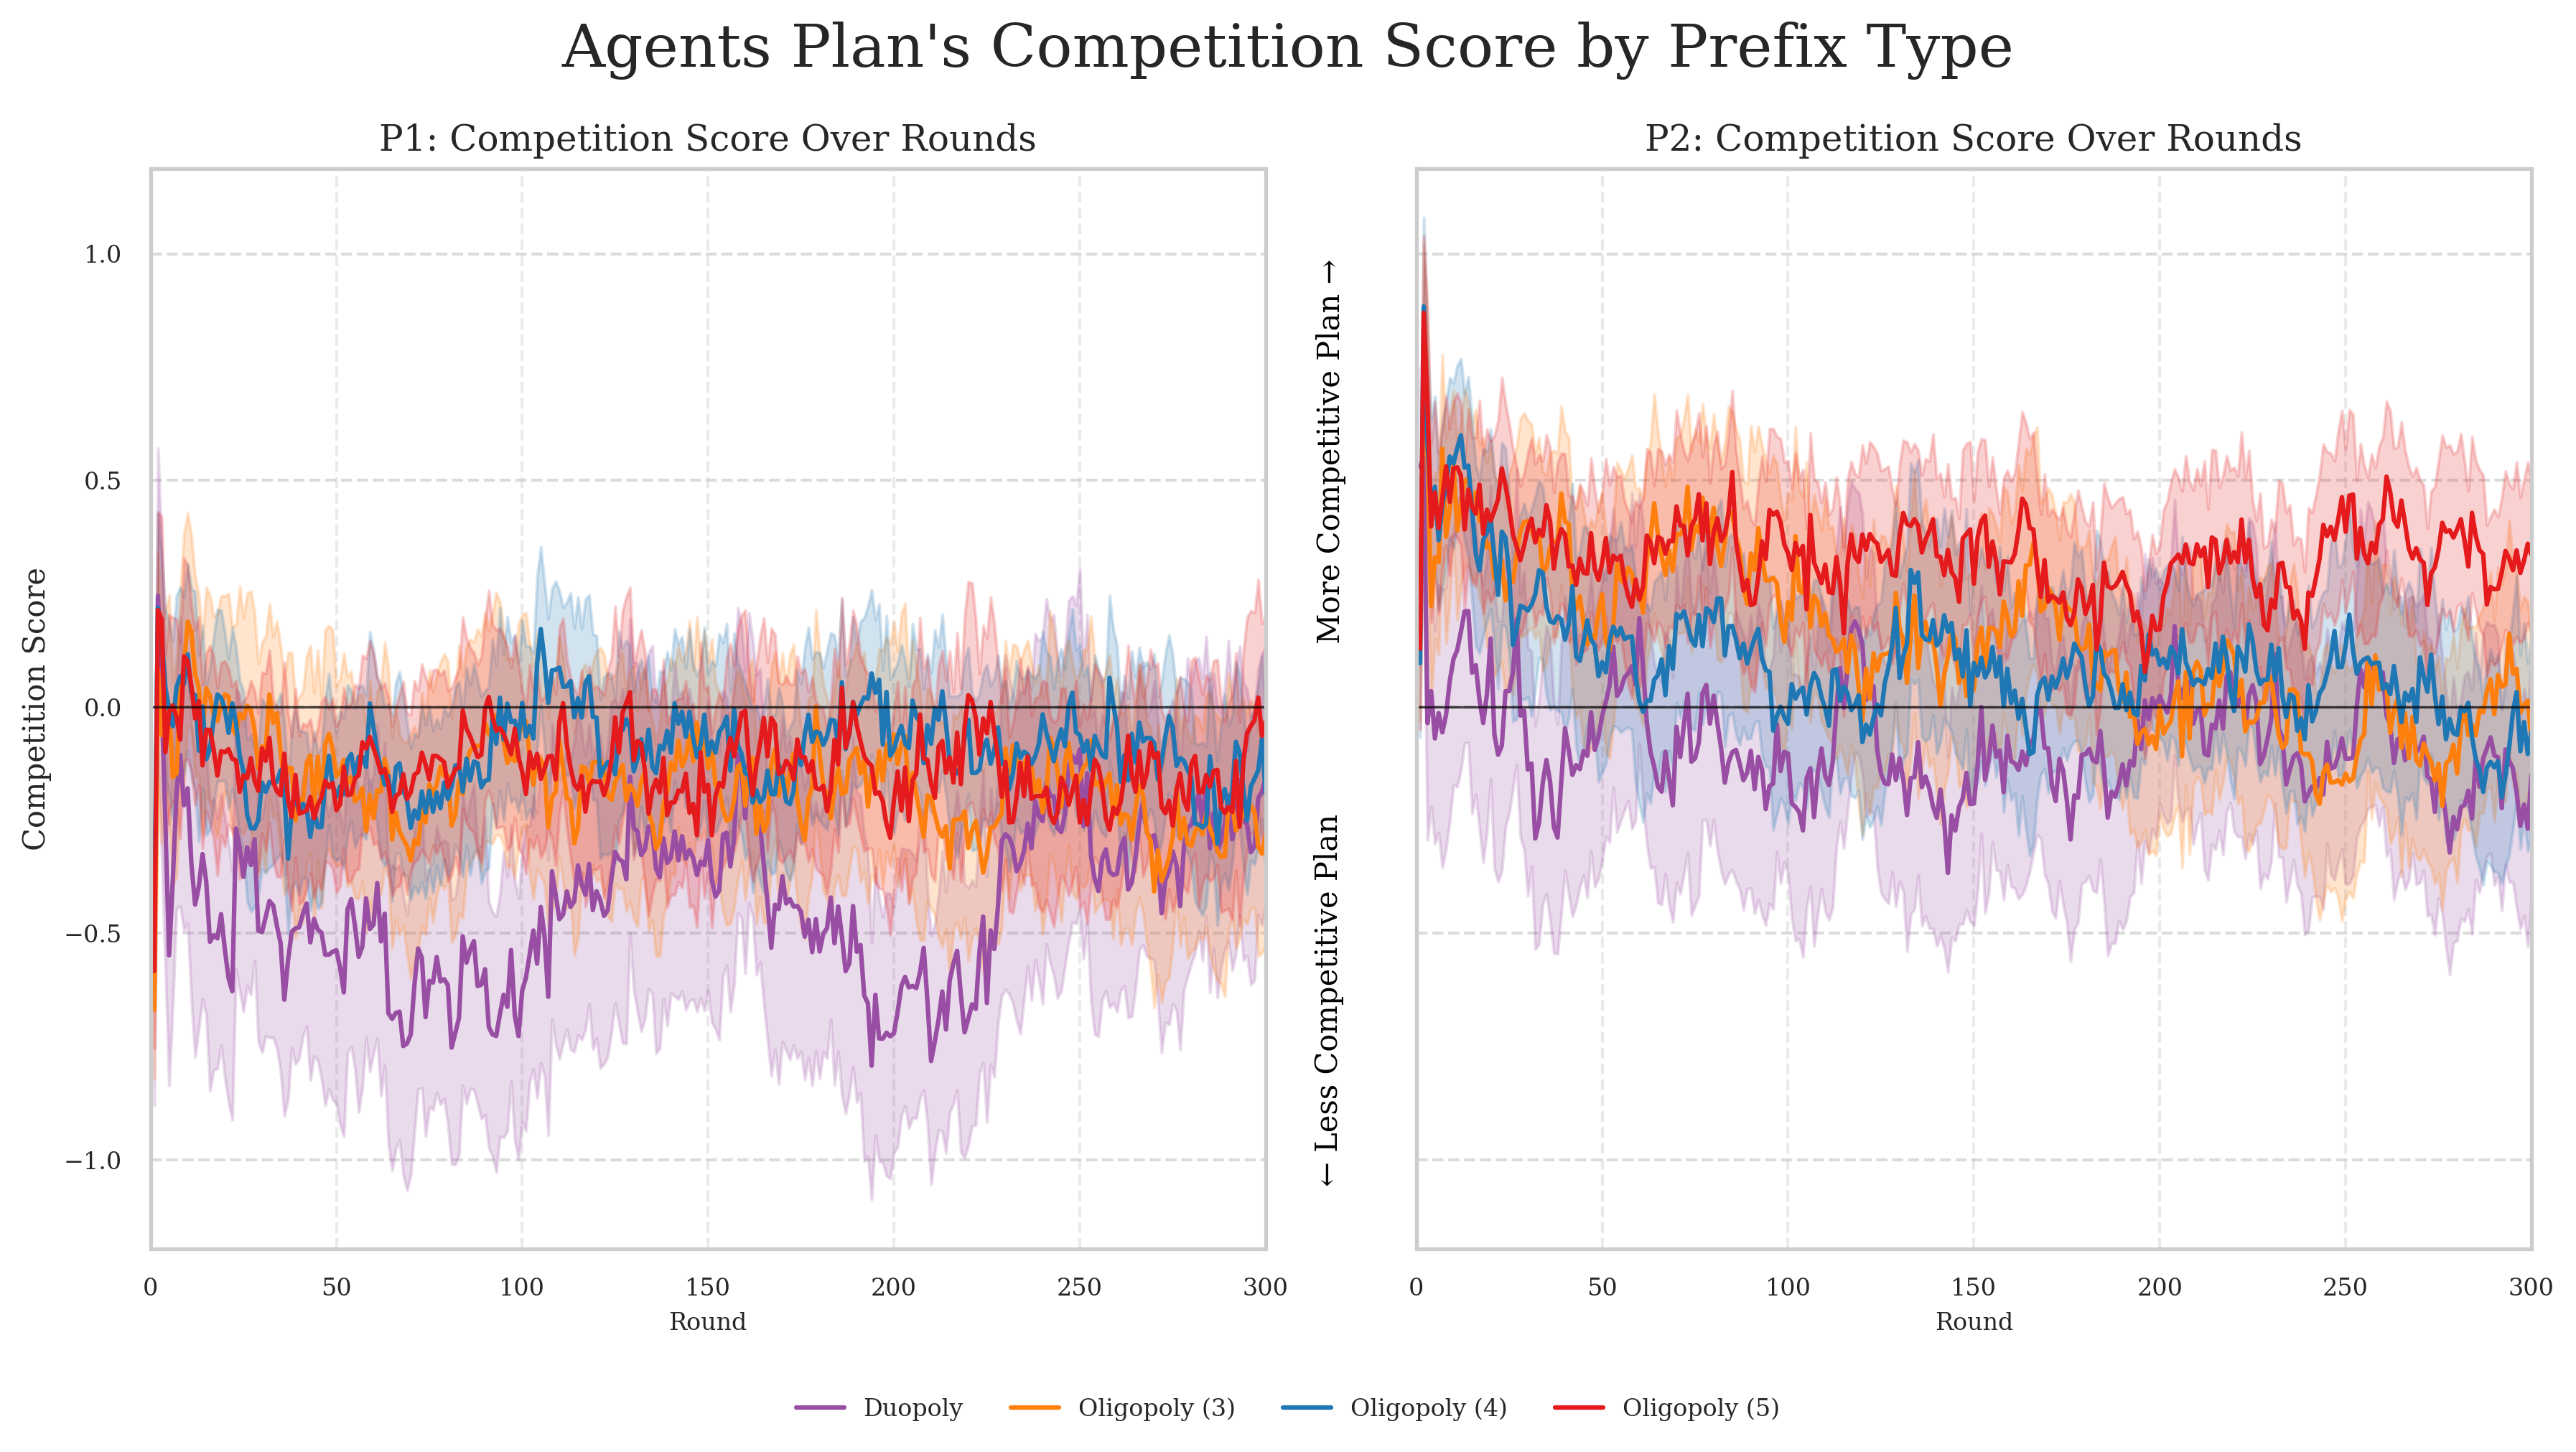

In [ ]:
df_plot_p1 = (
    df_scores.filter(pl.col("agent_prefix_type") == "P1")
    .select(["contrastive_score_norm", "round", "num_agents"])
    .to_pandas()
)

df_plot_p2 = (
    df_scores.filter(pl.col("agent_prefix_type") == "P2")
    .select(["contrastive_score_norm", "round", "num_agents"])
    .to_pandas()
)

df_plot_p1["num_agents"] = df_plot_p1["num_agents"].replace(
    {2: "Duopoly", 3: "Oligopoly (3)", 4: "Oligopoly (4)", 5: "Oligopoly (5)"}
)
df_plot_p2["num_agents"] = df_plot_p2["num_agents"].replace(
    {2: "Duopoly", 3: "Oligopoly (3)", 4: "Oligopoly (4)", 5: "Oligopoly (5)"}
)
# Set up subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Plot for P1
sns.lineplot(
    data=df_plot_p1,
    x="round",
    y="contrastive_score_norm",
    hue="num_agents",
    errorbar="ci",
    palette=colors[:4],
    ax=axes[0],
)
axes[0].set_xlim(0, 300)
axes[0].set_title("P1: Competition Score Over Rounds")
axes[0].set_xlabel("Round")
axes[0].set_ylabel("Competition Score", fontsize=10)
axes[0].grid(axis="y", linestyle="--", alpha=0.7)


# Get current y-axis limits to place arrows dynamically
ymin, ymax = axes[1].get_ylim()

# Add horizontal arrow for "More collusion" above zero
axes[1].annotate(
    "More Competitive Plan →",
    xy=(0.7, 0.65),
    xytext=(0.515, 0.775),
    xycoords="figure fraction",
    textcoords="figure fraction",
    rotation=90,
    ha="center",
    va="center",
    fontsize=10,
    color="black",
)

# Add horizontal arrow for "More competitive" below zero
axes[1].annotate(
    "← Less Competitive Plan",
    xy=(0.5, 0.35),
    xytext=(0.52, 0.35),
    xycoords="figure fraction",
    textcoords="figure fraction",
    rotation=90,
    ha="right",
    va="center",
    fontsize=10,
    color="black",
)

# Plot for P2
sns.lineplot(
    data=df_plot_p2,
    x="round",
    y="contrastive_score_norm",
    hue="num_agents",
    errorbar="ci",
    palette=colors[:4],
    ax=axes[1],
)
axes[1].set_xlim(0, 300)
axes[1].set_title("P2: Competition Score Over Rounds")
axes[1].set_xlabel("Round")
axes[1].set_ylabel("")  # No ylabel to avoid clutter
axes[1].grid(axis="y", linestyle="--", alpha=0.7)


# add horitonzal line at 0
for ax in axes:
    ax.axhline(0, color="black", linestyle="-", linewidth=0.8, alpha=0.7)

# Remove individual legends
axes[0].legend_.remove()
axes[1].legend_.remove()

# Add shared legend below the plots
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=4, bbox_to_anchor=(0.5, -0.05))

plt.tight_layout()
plt.subplots_adjust(bottom=0.1)
plt.suptitle("Agents Plan's Competition Score by Prefix Type", fontsize=20, y=1.05)
plt.savefig(OUTPUT_PATH / "competition_score_analysis_by_prefix_type.svg")
plt.show()

In [61]:
df_reg = df_scores.select(
    ["contrastive_score_norm", "num_agents", "round", "is_P1", "alpha", "price"]
).to_pandas()

# make alpha categorical
df_reg["alpha"] = df_reg["alpha"].astype("category")

model = smf.ols(
    "contrastive_score_norm ~ num_agents + round + is_P1 + alpha ", data=df_reg
).fit(cov_type="HC3")
print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     contrastive_score_norm   R-squared:                       0.063
Model:                                OLS   Adj. R-squared:                  0.063
Method:                     Least Squares   F-statistic:                     2347.
Date:                    Thu, 03 Jul 2025   Prob (F-statistic):               0.00
Time:                            22:29:41   Log-Likelihood:            -2.4456e+05
No. Observations:                  176400   AIC:                         4.891e+05
Df Residuals:                      176394   BIC:                         4.892e+05
Df Model:                               5                                         
Covariance Type:                      HC3                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Interc

In [ ]:
df_reg = df_scores.select(
    ["contrastive_score_norm", "num_agents", "round", "is_P1", "alpha", "price"]
).to_pandas()

# Create bins of 60 for 'round'
df_reg["round_bin"] = pd.cut(
    df_reg["round"],
    bins=range(0, df_reg["round"].max() + 60, 60),
    right=False,
    include_lowest=True,
)

# Make categorical variables
df_reg["alpha"] = df_reg["alpha"].astype("category")
df_reg["round_bin"] = df_reg["round_bin"].astype("category")

# Run regression using round_bin instead of round
model = smf.ols(
    "contrastive_score_norm ~ num_agents + round_bin + is_P1 + alpha", data=df_reg
).fit(cov_type="HC3")
print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     contrastive_score_norm   R-squared:                       0.063
Model:                                OLS   Adj. R-squared:                  0.063
Method:                     Least Squares   F-statistic:                     1465.
Date:                    Thu, 03 Jul 2025   Prob (F-statistic):               0.00
Time:                            22:32:28   Log-Likelihood:            -2.4376e+05
No. Observations:                  175812   AIC:                         4.875e+05
Df Residuals:                      175803   BIC:                         4.876e+05
Df Model:                               8                                         
Covariance Type:                      HC3                                         
                                                     coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------

In [ ]:
df_reg = df_scores.select(
    ["contrastive_score_norm", "num_agents", "round", "is_P1", "alpha", "price"]
).to_pandas()

# Create bins of 60 for 'round'
df_reg["round_bin"] = pd.cut(
    df_reg["round"],
    bins=range(0, df_reg["round"].max() + 60, 60),
    right=False,
    include_lowest=True,
)

# Make categorical variables
df_reg["alpha"] = df_reg["alpha"].astype("category")
df_reg["round_bin"] = df_reg["round_bin"].astype("category")
df_reg["num_agents"] = df_reg["num_agents"].astype("category")
# make price lag
df_reg["price_lag"] = df_reg["price"].shift(1)
df_reg["price_lag2"] = df_reg["price"].shift(2)
df_reg["price_lag3"] = df_reg["price"].shift(3)

# Run regression using round_bin instead of round
model = smf.ols(
    "contrastive_score_norm ~ num_agents + round_bin + is_P1 + alpha", data=df_reg
).fit(cov_type="HC3")
print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     contrastive_score_norm   R-squared:                       0.065
Model:                                OLS   Adj. R-squared:                  0.065
Method:                     Least Squares   F-statistic:                     1209.
Date:                    Thu, 03 Jul 2025   Prob (F-statistic):               0.00
Time:                            22:51:02   Log-Likelihood:            -2.4355e+05
No. Observations:                  175812   AIC:                         4.871e+05
Df Residuals:                      175801   BIC:                         4.872e+05
Df Model:                              10                                         
Covariance Type:                      HC3                                         
                                                     coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------